## 기본 라이브러리 설정

In [116]:
## 1. 기본
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 2. 훈련 검증용 데이터 분리
from sklearn.model_selection import train_test_split

# 3. 교차검증
from sklearn.model_selection import cross_validate

# 4. 정규화
from sklearn.preprocessing import StandardScaler

# 5. 분류모델 구축
# 1) ★K-최근접이웃(KNN, 이웃값 조정)
from sklearn.neighbors import KNeighborsClassifier 
# 2) ★로지스틱 회귀모델
from sklearn.linear_model import LogisticRegression 
# 3) 확률적 경사 하강법
from sklearn.linear_model import SGDClassifier 
# 4) 결정트리
from sklearn.tree import DecisionTreeClassifier
# 5) 앙상블 모델
from sklearn.ensemble import RandomForestClassifier # ★랜덤포레스트
from sklearn.ensemble import ExtraTreesClassifier # 엑스트라 트리
from sklearn.ensemble import GradientBoostingClassifier # ★그레디언트 부스팅
from sklearn.ensemble import HistGradientBoostingClassifier # ★히스토그램 기반 그레디언트 부스팅

from xgboost import XGBClassifier # xgboost
from lightgbm import LGBMClassifier # lightgbm

### 1. 데이터 불러오기

In [117]:
# 데이터 불러오기
df = pd.read_csv("./data/06_(문제)타이타닉_분류_데이터셋.csv")
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [118]:
### <변수설명>
# PassengerId : 각 승객의 고유 번호
# Survived : 생존 여부(종속 변수)
#     0 = 사망
#     1 = 생존
# Pclass : 객실 등급 - 승객의 사회적, 경제적 지위
#     1st = Upper(first class)
#     2nd = Middle(second class)
#     3rd = Lower(third class)
# Name : 이름
# Sex : 성별
# Age : 나이
# SibSp : 동반한 Sibling(형제자매)와 Spouse(배우자)의 수
# Parch : 동반한 Parent(부모) Child(자식)의 수
# Ticket : 티켓의 고유넘버
# Fare : 티켓의 요금
# Cabin : 객실 번호
# Embarked : 승선한 항
#     C = Cherbourg
#     Q = Queenstown
#     S = Southampton

In [119]:
# 결측치, 이상치 확인하기
df.info()
df.describe()

### 
# 1. age 결측치 제거
# 2. deck, embark_town(embarked와 동일), class(pclass 동일), alive(survived 동일) , alone(sibsp와 동일)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   survived     891 non-null    int64  
 1   pclass       891 non-null    int64  
 2   sex          891 non-null    object 
 3   age          714 non-null    float64
 4   sibsp        891 non-null    int64  
 5   parch        891 non-null    int64  
 6   fare         891 non-null    float64
 7   embarked     889 non-null    object 
 8   class        891 non-null    object 
 9   who          891 non-null    object 
 10  adult_male   891 non-null    bool   
 11  deck         203 non-null    object 
 12  embark_town  889 non-null    object 
 13  alive        891 non-null    object 
 14  alone        891 non-null    bool   
dtypes: bool(2), float64(2), int64(4), object(7)
memory usage: 92.4+ KB


,survived,pclass,age,sibsp,parch,fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [120]:
df.groupby(["sex", "survived"])["survived"].count()

sex     survived
female  0            81
        1           233
male    0           468
        1           109
Name: survived, dtype: int64

<AxesSubplot:xlabel='sex', ylabel='survived'>

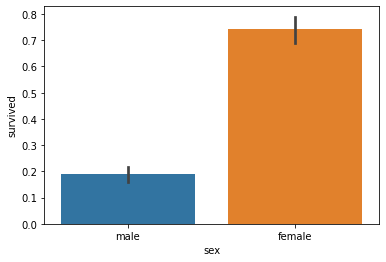

In [121]:
sns.barplot(x="sex", y="survived", data=df)

<AxesSubplot:xlabel='pclass', ylabel='survived'>

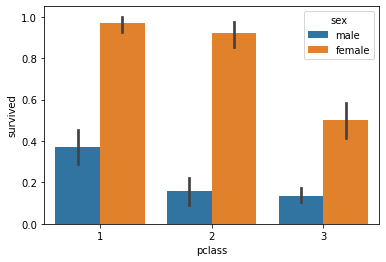

In [122]:
sns.barplot(x="pclass", y="survived", hue="sex", data=df)

### (해석)
# 여성의 경우 3등실의 경우 생존확률이 상대적으로 떨어짐
# 남성의 경우 1등실의 생존확률이 2,3등실에 비해 상대적으로 높음

In [123]:
### age에 따라 구분값 반환 함수 설정
def get_category(age):
    cat = ""
    if age <= -1 : cat = "Unknown"
    elif age <= 5  : cat = "baby"
    elif age <= 12 : cat = "child"
    elif age <= 18 : cat = "teenager"
    elif age <= 25 : cat = "student"
    elif age <= 35 : cat = "young adult"
    elif age <= 60 : cat = "adult"
    else : cat = "elderly"
    
    return cat

<AxesSubplot:xlabel='age_cat', ylabel='survived'>

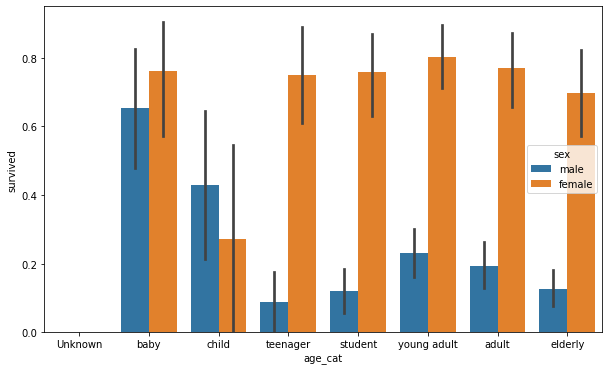

In [124]:
plt.figure(figsize=(10,6))

group_names = ["Unknown", "baby","child","teenager","student","young adult","adult","elderly"]

df["age_cat"] = df["age"].apply(lambda x : get_category(x))
sns.barplot(x="age_cat", y="survived", hue="sex", data=df, order=group_names)

### (해석)
# 

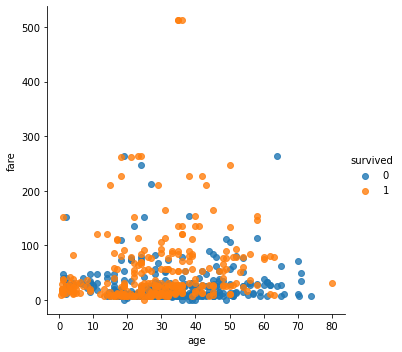

In [125]:
sns.lmplot(x="age", y="fare", data=df, hue="survived", fit_reg=False)

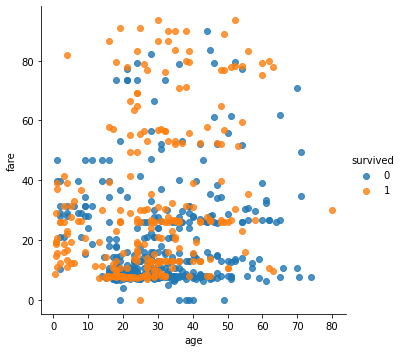

In [126]:
sns.lmplot(x="age", y="fare", data=df[df.fare <100], hue="survived", fit_reg=False)

In [127]:
print(np.sort(df["sibsp"].unique()))
print(np.sort(df["parch"].unique()))

[0 1 2 3 4 5 8]
[0 1 2 3 4 5 6]


### 2. 데이터 전처리

In [128]:
df.columns

Index(['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare',
       'embarked', 'class', 'who', 'adult_male', 'deck', 'embark_town',
       'alive', 'alone', 'age_cat'],
      dtype='object')

In [129]:
df["age"].fillna(df["age"].mean())

0      22.000000
1      38.000000
2      26.000000
3      35.000000
4      35.000000
         ...    
886    27.000000
887    19.000000
888    29.699118
889    26.000000
890    32.000000
Name: age, Length: 891, dtype: float64

In [130]:
df["age"] = df["age"].fillna(df["age"].mean())

In [131]:
df

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone,age_cat
0,0,3,male,22.000000,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False,student
1,1,1,female,38.000000,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False,adult
2,1,3,female,26.000000,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True,young adult
3,1,1,female,35.000000,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False,young adult
4,0,3,male,35.000000,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True,young adult
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.000000,0,0,13.0000,S,Second,man,True,NaN,Southampton,no,True,young adult
887,1,1,female,19.000000,0,0,30.0000,S,First,woman,False,B,Southampton,yes,True,student
888,0,3,female,29.699118,1,2,23.4500,S,Third,woman,False,NaN,Southampton,no,False,elderly
889,1,1,male,26.000000,0,0,30.0000,C,First,man,True,C,Cherbourg,yes,True,young adult


In [132]:
df = df[['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked']].dropna().reset_index(drop=True)

df

,survived,pclass,sex,age,sibsp,parch,fare,embarked
0,0,3,male,22.000000,1,0,7.2500,S
1,1,1,female,38.000000,1,0,71.2833,C
2,1,3,female,26.000000,0,0,7.9250,S
3,1,1,female,35.000000,1,0,53.1000,S
4,0,3,male,35.000000,0,0,8.0500,S
...,...,...,...,...,...,...,...,...
884,0,2,male,27.000000,0,0,13.0000,S
885,1,1,female,19.000000,0,0,30.0000,S
886,0,3,female,29.699118,1,2,23.4500,S
887,1,1,male,26.000000,0,0,30.0000,C


In [133]:
# 원핫 인코딩
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

df.loc[:, "sex"] = LabelEncoder().fit_transform(df["sex"])
df.loc[:, "embarked"] = LabelEncoder().fit_transform(df["embarked"])

# pd.get_dummies(data = df, columns = ['embarked'], prefix = 'embarked')

In [134]:
df.corr()

,survived,pclass,sex,age,sibsp,parch,fare,embarked
survived,1.000000,-0.335549,-0.541585,-0.074673,-0.034040,0.083151,0.255290,-0.169718
pclass,-0.335549,1.000000,0.127741,-0.327954,0.081656,0.016824,-0.548193,0.164681
sex,-0.541585,0.127741,1.000000,0.089434,-0.116348,-0.247508,-0.179958,0.110320
age,-0.074673,-0.327954,0.089434,1.000000,-0.231875,-0.178232,0.088604,-0.028927
sibsp,-0.034040,0.081656,-0.116348,-0.231875,1.000000,0.414542,0.160887,0.068900
parch,0.083151,0.016824,-0.247508,-0.178232,0.414542,1.000000,0.217532,0.040449
fare,0.255290,-0.548193,-0.179958,0.088604,0.160887,0.217532,1.000000,-0.226311
embarked,-0.169718,0.164681,0.110320,-0.028927,0.068900,0.040449,-0.226311,1.000000


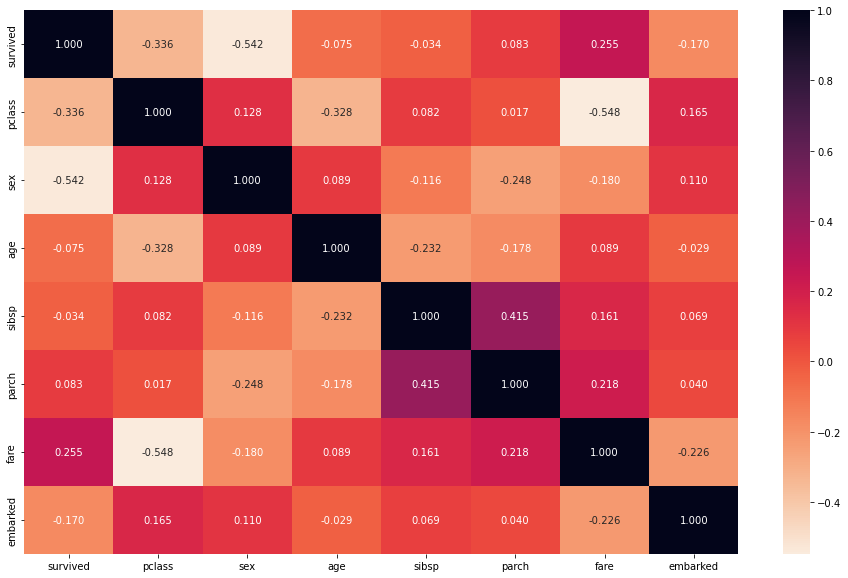

In [135]:
# 변수 상관관계 분석
plt.figure(figsize = (16,10))
sns.heatmap(df.corr(), annot=True, fmt = '.3f', cmap='rocket_r')
plt.show()

In [136]:
# pd.get_dummies(data = df, columns = ['embarked'], prefix = 'embarked')

In [137]:
data = df[['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked']].to_numpy()
target = df["survived"].to_numpy()

In [138]:
train_input, test_input, train_target, test_target = \
    train_test_split(data, target, test_size=0.2, random_state=42)
    
print(train_input.shape, train_target.shape)
print(test_input.shape, test_target.shape)

(711, 7) (711,)
(178, 7) (178,)


In [139]:
hgb = HistGradientBoostingClassifier(random_state=42)

scores = cross_validate(hgb, train_input, train_target,
                        return_train_score=True, n_jobs=-1)

print("히스토그램 기반 그레디언트 부스팅")
print("훈련 :",np.mean(scores["train_score"]), "/" , "테스트 :", np.mean(scores["test_score"]))

print("---------------------------------------------------------")

gb = GradientBoostingClassifier(random_state=42)

scores = cross_validate(gb, train_input, train_target,
                        return_train_score=True, n_jobs=-1)

print("그레디언트 부스팅")
print("훈련 :",np.mean(scores["train_score"]), "/" , "테스트 :", np.mean(scores["test_score"]))

print("---------------------------------------------------------")
rt = RandomForestClassifier(random_state=42)

scores = cross_validate(rt, train_input, train_target,
                        return_train_score=True, n_jobs=-1)

print("랜덤포레스트")
print("훈련 :",np.mean(scores["train_score"]), "/" , "테스트 :", np.mean(scores["test_score"]))

히스토그램 기반 그레디언트 부스팅
훈련 : 0.9458538577687566 / 테스트 : 0.8284447946419778
---------------------------------------------------------
그레디언트 부스팅
훈련 : 0.9135028094754821 / 테스트 : 0.8270067960208806
---------------------------------------------------------
랜덤포레스트
훈련 : 0.9876940023267903 / 테스트 : 0.8171771890081748


In [140]:
### 정규화

ss = StandardScaler()
ss.fit(train_input)
train_scaled = ss.transform(train_input)
test_scaled = ss.transform(test_input)

kn = KNeighborsClassifier(n_neighbors=3)
kn.fit(train_scaled, train_target)
print("KNN")
print("훈련 :", kn.score(train_scaled, train_target), "/", "테스트 :", kn.score(test_scaled, test_target))

print("---------------------------------------------------------")

lr = LogisticRegression()
lr.fit(train_scaled, train_target)

print("로지스틱 회귀분석")
print("훈련 :", lr.score(train_scaled, train_target), "/", "테스트 :", lr.score(test_scaled, test_target))

print("---------------------------------------------------------")

dt = DecisionTreeClassifier(max_depth=6, random_state=42)

dt.fit(train_scaled, train_target)

print("결정트리")
print("훈련 :", dt.score(train_scaled, train_target), "/", "테스트 :", dt.score(test_scaled, test_target))

KNN
훈련 : 0.8776371308016878 / 테스트 : 0.7865168539325843
---------------------------------------------------------
로지스틱 회귀분석
훈련 : 0.8002812939521801 / 테스트 : 0.7752808988764045
---------------------------------------------------------
결정트리
훈련 : 0.870604781997187 / 테스트 : 0.8202247191011236


In [ ]:
"""
가. 타이타닉 생존률 판단을 위한 모델을 분석한 결과
독립변수는 data에 있는 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked' 사용
종속변수는 target에 있는 'survived(사망 0, 생존 1)을 기준으로 
훈련, 테스트 데이터를 구분하였다.

나. 앙상블 모델을 적용한 결과 과대적합이 나와 해당 모델은 적용하지 않았다.

<모델 적용 결과>
1. 히스토그램 기반 그레디언트 부스팅
훈련 : 0.9458538577687566 / 테스트 : 0.8284447946419778
---------------------------------------------------------
2. 그레디언트 부스팅
훈련 : 0.9135028094754821 / 테스트 : 0.8270067960208806
---------------------------------------------------------
3. 랜덤포레스트
훈련 : 0.9876940023267903 / 테스트 : 0.8171771890081748
---------------------------------------------------------
4. KNN
훈련 : 0.8776371308016878 / 테스트 : 0.7865168539325843
---------------------------------------------------------
5. 로지스틱 회귀분석
훈련 : 0.8002812939521801 / 테스트 : 0.7752808988764045
---------------------------------------------------------
6. 결정트리
훈련 : 0.870604781997187 / 테스트 : 0.8202247191011236

다. 따라서 모델 적용 결과 "로지스틱 회귀 모델"과 "결정트리 모델"을 선정할 수 있다.
1) 로지스틱 회귀모델 (0.03)
훈련 : 0.8002812939521801 / 테스트 : 0.7752808988764045

2) 결정트리 모델 (0.05)
훈련 : 0.870604781997187 / 테스트 : 0.8202247191011236

라. 로지스틱 회귀모델은 정확도 오차가 작지만, 훈련 정확도가 너무 낮아 모델을 사용하지 않는 것이 좋다고 판단된다.
    상대적으로 훈련 정확도가 높고 정확도 오차가 작은 결정트리 모델을 선택하여 타이타닉 생존률에 대한 분석 모델을 선택해야 한다.
""" 